# Feature clustering
> In this article, I will show how the previously described framework of optimal probabilistic clustering can be extended to feature clustering. The problem of feature (or variable) clustering arises in several aspects of systematic trading, like portfolio construction, feature selection, among others.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Feature Clustering, Clustering, Correlation Distance]
- image: images/post_feature_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

## Introduction

Typical clustering algorithms aim at grouping similar observations defined on top of a feature space, where similarity is quantified by a given distance metric.

Clustering can also be conducted on the set of features themselves, these becoming the observations. In a previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/distance%20metrics/variation%20of%20information/correlation%20distance/2021/02/21/distance_metrics.html), I have described metrics that allow us to calculate distances between features. Once these metrics are available, feature clustering follows naturally. Here, I will extend the previously described framework of optimal probabilistic clustering - check [Part I](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/2021/02/12/optimal_probabilistic_clustering_part1.html) and [Part II](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/regularization/2021/03/09/optimal_probabilistic_clustering_part2.html) - to (optimal probabilistic) feature clustering.

Feature clustering allows us to infer redundant features and conduct feature selection. More specific to the systematic investment process, better portfolios can be constructed once we are able to systematically cluster similar securities {% cite Prado2020 %}. In particular, the Hierarchical Risk Parity (HRP) method is built on top of feature clustering {% cite Prado2016 %}.

**Note:** For the sake of reproducibility of the results described in this article, all random processes are conducted using a fixed seed.

In [1]:
random_seed = 41

## Concepts Review

Let's begin by reviewing some concepts I have previously described, necessary to build our probabilistic feature clustering framework.

### Correlation distance

We need to be able to infer similarity (or dissimilarity) between features. Quantities like correlation, mutual information, etc, can be helpful, but they are not true metrics. However, true metrics can be derived from these quantities. In particular, from the correlation coefficient, we can define the correlation distance and, from the mutual information we can define the variation of information. For further details please check my previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/distance%20metrics/variation%20of%20information/correlation%20distance/2021/02/21/distance_metrics.html). Here, and for the sake of simplicity, I will only use the one-side correlation distance, defined as:

$$ d_{\vert \rho \vert} (X,Y) = \sqrt{1 - \vert \rho(X,Y) \vert}, $$

where $\rho(X,Y)$ is the correlation coefficient between feature $X$ and $Y$. All the discussion that follows is completely generic to whatever metric we choose to use. In particular, if the dependencies between our features are nonlinear, variation of information may be a better choice of metric.


While working with true metrics is not strictly necessary to perform feature clustering, correlation distance and variation of information have better properties when it comes to measuring feature similarity. Besides, one of the approaches I will describe here implies directly using the distance between features when running the clustering algorithm. In this case, using true metrics becomes strictly necessary.

### Optimal probabilisitic clustering

In order to perform optimal probabilistic clustering, I'm going to use the same framework described in my previous series of articles - [Part I](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/2021/02/12/optimal_probabilistic_clustering_part1.html) and [Part II](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/regularization/2021/03/09/optimal_probabilistic_clustering_part2.html) - which builds on top of the fc-means algorithm {% cite Dias2019 %}. However, the source code has been modified to allow us to run the algorithm using an arbitrary distance metric - *metric_func* - which is sent as an argument to the class constructor:

In [2]:
#collapse-show
import numpy as np
import scipy.linalg

class FCM:
    def __init__(self, metric_func, n_clusters=10, max_iter=50, m=2, error=1e-5, random_state=42):
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state
        self.metric_func = metric_func

    def fit(self, X):
        N = X.shape[0]
        C = self.n_clusters
        centers = []

        r = np.random.RandomState(self.random_state)
        u = r.rand(N,C)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T,C)

        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()

            centers = self.next_centers(X, u)
            u = self.next_u(X, centers)
            iteration += 1

            # Stopping rule
            if scipy.linalg.norm(u - u2) < self.error:
                break

        self.u = u
        self.centers = centers
        return self

    def next_centers(self, X, u):
        um = u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def next_u(self, X, centers):
        return self._predict(X, centers)

    def _predict(self, X, centers):
        power = float(2 / (self.m - 1))
        temp = self.metric_func(X.T, centers.T) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_
        return 1 / denominator_.sum(2)

    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        u = self._predict(X, self.centers)
        return np.argmax(u, axis=-1)
    
    

The metric function - *metric_func* - is built such that it takes two arrays $A$ and $B$ as arguments, of sizes ($N$, $n_A$) and ($N$, $n_B$), respectively, with $N$ the number of observations and $n_A$ and $n_B$ the number of features in $A$ and $B$, respectively. The output is the distance between the features in $A$ and the features in $B$, thus of size ($n_A$, $n_B$).


We are going to make use of both the Euclidean distance (Minkowski distance with parameter $p=2$, but kept here the possibility of other values of $p$),

In [3]:
from scipy.spatial.distance import cdist
def minkowski_distance(A, B):
    return cdist(A.T, B.T, metric="minkowski", p=2)

and the one-sided correlation distance as defined above,

In [4]:
def correlation_distance(A, B):
    N = A.shape[0]
    cov = (A.T@B)/N - np.tensordot(np.mean(A,0), np.mean(B,0), axes=0)
    corr = cov / np.tensordot(np.std(A,0), np.std(B,0), axes=0)-1e-9
    dist = np.sqrt(1-np.abs(corr))
    return dist

In the following, we are going to use some of the functions I have described in my previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/2021/02/12/optimal_probabilistic_clustering_part1.html) on optimal probabilistic clustering. Refer to that for further details. Here, the only difference is a ability to use the user-defined distance metric - *metric_func*:

In [5]:
#collapse-show
def run_cluster(metric_func, n_clusters, data, seed=42):
    # membership probabilities
    model = FCM(metric_func=metric_func, n_clusters=n_clusters, random_state=seed)
    model = model.fit(data)
    p = model.u
    centers = model.centers
    # representative cluster
    representative_cluster = np.argmax(p, 1)
    # membership entropy
    Sx = -np.sum(p*np.log(p), 1) / np.log(n_clusters)
    # total membership entropy (across the entire feature space)
    S = np.sum(Sx)        
    
    return centers, p, representative_cluster, Sx, S

In [6]:
#collapse-show
def minimize_membership_entropy(dataset, metric_func, max_clusters=10, lamb=0, seed=42, n_seeds=1):
    
    # The number of clusters to try
    n_clusters_trials = np.arange(2, max_clusters+1, 1)
    
    # Creates the seeds
    if n_seeds == 1:
        seeds = np.array([seed])
    else:
        rand = np.random.RandomState(seed=seed)
        seeds = rand.randint(low=1, high=1e9, size=n_seeds)
        
    # Runs the clustering for different seeds and number of clusters
    total_entropies = list()
    
    for seed in seeds:
        total_entropies_ = list()
        for trial in n_clusters_trials:
            _, _, _, _, total_entropy = run_cluster(metric_func  = metric_func,
                                                    n_clusters   = trial, 
                                                    data         = dataset, 
                                                    seed         = seed)
            total_entropies_.append(total_entropy+lamb*trial)
        total_entropies.append(total_entropies_)
    total_entropies = np.array(total_entropies)
        
    # Finds the optimal number of clusters and the respective seed
    location = np.argwhere(total_entropies == np.min(total_entropies))[0]
    optimal_seed = seeds[location[0]]
    optimal_nclusters = n_clusters_trials[location[1]]
    
    return optimal_seed, optimal_nclusters, total_entropies

## Experimental results

### Synthetic datasets

Let's now create synthetic datasets to assess the performance of the feature clustering framework. We want to uniformly sample $(n,k,m)$ partitions, with $n$ the total number of features, $k$ the number of clusters, and $m$ the minimum number of features per cluster. I'm going to use the same approach as in a previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/regularization/2021/03/09/optimal_probabilistic_clustering_part2.html):

In [7]:
def construct_random_partition(n, k, m, seed=None):
    rand = np.random.RandomState(seed=seed)
    parts = rand.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

As a example:

In [8]:
construct_random_partition(n=10, k=4, m=2, seed=random_seed)

array([3, 2, 3, 2])

Once a $(n,k,m)$ partition has been sampled, we need to draw the observations of each feature. For each cluster $i$, we draw a base sample of *n_observations* from a standard normal distribution. Each feature belonging to cluster $i$ is populated by summing to the base sample another set of *n_observations* from a normal distribution of standard deviation *sigma*. The larger the *sigma*, the larger the intra-cluster distance between features. Below is the function that implements this structure:

In [9]:
from scipy.stats import norm

def generate_realization(n, k, m, n_observations, sigma, seed=None):
    partition = construct_random_partition(n=n, k=k, m=m, seed=seed)
    rand = np.random.RandomState(seed=seed)
    base_samples = rand.normal(0, 1, (n_observations, len(partition)))
    dataset = sigma*rand.normal(0, 1, (n_observations, n))
    j = 0
    for h, value in enumerate(partition):
        base_sample = base_samples[:,h]
        for i in range(0, value): 
            dataset[:,j] += base_sample
            j+=1
    return dataset, partition

While the above process only allows for controlling the intra-cluster feature similarity, with inter-cluster features being uncorrelated on average, the same could be easily extended to allow a varying degree of dependence between features of different clusters.

In the experiments that follow, we are going to consider the following set of parameters:

In [10]:
n = 200
k = 8
m = 5
n_observations = 1000
sigma = 0.4

dataset, partition = generate_realization(n              = n, 
                                          k              = k, 
                                          m              = m, 
                                          n_observations = n_observations, 
                                          sigma          = sigma, 
                                          seed           = random_seed)

Let's now calculate both the correlation coefficient and the correlation distance between all the features in our partition:

In [11]:
# Correlation coefficient
import pandas as pd
correlation_matrix = pd.DataFrame(dataset).corr()

# Correlation distance
correlation_distance_matrix = correlation_distance(A=dataset, B=dataset)

And let's plot the results:

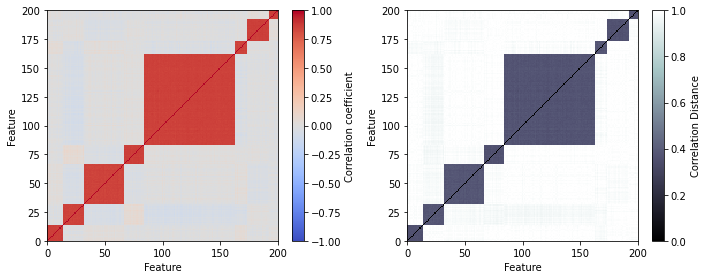

In [12]:
#collapse-hide
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
axes0 = plt.axes([0.05, 0.05, 0.40, 0.80])
plot0 = axes0.pcolor(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
axes0.set_xlabel("Feature")
axes0.set_ylabel("Feature")
cbar0 = fig.colorbar(plot0)
cbar0.set_label('Correlation coefficient', rotation=90)
axes1 = plt.axes([0.55, 0.05, 0.40, 0.80])
plot1 = axes1.pcolor(correlation_distance_matrix, cmap="bone", vmin=0, vmax=1)
axes1.set_xlabel("Feature")
axes1.set_ylabel("Feature")
cbar1 = fig.colorbar(plot1)
cbar1.set_label('Correlation Distance', rotation=90)
plt.show()

For later comparison, let's create labels to map each feature to its respective cluster. This will be the ground truth we want the optimal clustering algorithm to recover:

In [13]:
cluter_assignment_true = np.array([i for i in range(0, len(partition)) for j in range(0, partition[i])])

**Note:** In a more sophisticated treatment of the problem, it may be a good idea to denoise the correlation matrix and, consequently, the distance matrix, before starting the clustering algorithm. There are a few ways this can be pursued. In the context of Principal Component Analysis (PCA), components associated with smaller eigenvalues may be associated with noise and hence removed from the reconstruction of the original dataset. Another technique involves using random matrix theory to infer the eigenmodes associated with noise. This is nicely described by {% cite Prado2020 %}. Here, for the sake of simplicity, I'm going to ignore this step and proceed with two possible approaches to feature clustering.

### Feature clustering - based on observation matrix

The first approach I'm describing for feature clustering involves building an observation matrix, of size $n\times n$, with $n$ the total number of features as before, whose entries quantify some sort of similarity (or dissimilarity) between features. While simple correlation is a valid option, correlation distance has properties that may be deemed more desirable - check, for instance, {% cite Prado2020 %}. Other possible options include:

- Mutual information
- Mutual information score - check previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/information%20theory/mutual%20information/feature%20selection/feature%20importance/2021/02/06/mutal_information_and_feature_selection.html)
- Variation of information - check previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/distance%20metrics/variation%20of%20information/correlation%20distance/2021/02/21/distance_metrics.html)
- Two-sided correlation distance - check previous [article](https://joaodmrodrigues.github.io/elements-financial-machine-learning/distance%20metrics/variation%20of%20information/correlation%20distance/2021/02/21/distance_metrics.html)
- etc

Here, I will use the one-sided correlation distance. The observation matrix is then the correlation distance matrix calculated above:

In [14]:
observation_matrix = correlation_distance_matrix 

Let's now find the optimal number of clusters by minimizing the total membership entropy. The clustering algorithm is set to use the Euclidean distance to calculate the distance between observations of the observation matrix, which correspond to the distance between the features themselves.

In [15]:
max_clusters = 10
optimal_seed, optimal_nclusters, total_entropies = minimize_membership_entropy(dataset      = observation_matrix, 
                                                                               metric_func  = minkowski_distance,
                                                                               max_clusters = max_clusters, 
                                                                               lamb         = 0, 
                                                                               seed         = random_seed, 
                                                                               n_seeds      = 50)
print("Optimal number of clusters =", optimal_nclusters)

Optimal number of clusters = 8


Let's also plot the full entropy minimization results:

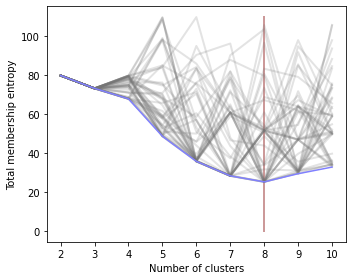

In [16]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

axes.plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
for i in range(0, total_entropies.shape[0]):
    axes.plot(np.arange(2, max_clusters+1, 1), total_entropies[i,:], color=(0.46,0.46,0.46,0.2), linewidth=2)
axes.plot(np.arange(2, max_clusters+1, 1), np.min(total_entropies,0), color=(0.5,0.5,1.0))
axes.set_xlabel('Number of clusters')
axes.set_ylabel('Total membership entropy')

plt.tight_layout()
plt.show()

The optimal clustering algorithm correctly predicts the number of clusters. Let's now fix it and rerun the final clustering using the optimal seed:

In [17]:
centers, p, representative_cluster, Sx, S = run_cluster(metric_func = minkowski_distance,
                                                        n_clusters  = optimal_nclusters, 
                                                        data        = observation_matrix, 
                                                        seed        = optimal_seed)
print("Total membership entropy =", np.round(S, 2))

Total membership entropy = 25.2


While we have correctly inferred the number of clusters, we are now interested in checking if the cluster assignment is correct. For that purpose, let's define the $n \times n$ affinity matrix $Z$ such that $Z_{ij} \in \lbrace \mathrm{null}, 0, 1, ... , k^* \rbrace$ and $Z_{ij} =z$ if and only if $i$ and $j$ both belong to cluster $z$, otherwise if $i$ and $j$ belong to different clusters $Z_{ij} = \mathrm{null}$.

Let's calculate both the actual affinity matrix (ground truth), and that retrieved from the optimal clustering algorithm, using the representative clusters of each observation (feature):

In [18]:
### Affinity matrix - real
aux2 = np.repeat([cluter_assignment_true], cluter_assignment_true.shape[0], axis=0)
affinity_real = aux2==aux2.T
Z_real = np.array(affinity_real, dtype=float)
Z_real[affinity_real==False] = np.nan
for i in range(0, affinity_real.shape[1]):
    inds = np.where(affinity_real[i,:]==True)[0]
    Z_real[i, inds] = cluter_assignment_true[i]

### Affinity matrix - retrieved from the optimal clustering framework
aux1 = np.repeat([representative_cluster], representative_cluster.shape[0], axis=0)
affinity_clustering = aux1==aux1.T
Z_clustering = np.array(affinity_clustering, dtype=float)
Z_clustering[affinity_clustering==False] = np.nan
for i in range(0, affinity_real.shape[1]):
    inds = np.where(affinity_clustering[i,:]==True)[0]
    Z_clustering[i, inds] = representative_cluster[i]

Let's now plot the affinity matrices:

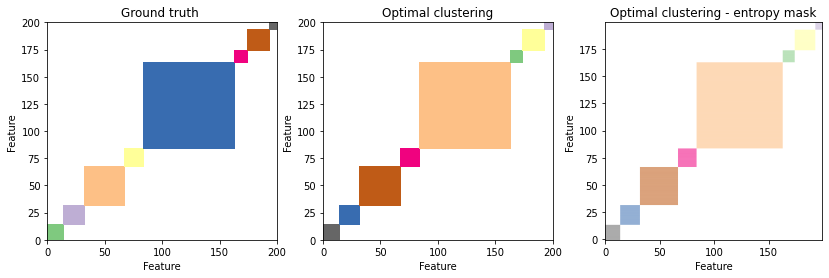

In [19]:
#collapse-hide
### Handles the colors
from matplotlib import cm
import matplotlib
def make_rgb_transparent(rgb, alpha):
    bg_rgb = [1, 1, 1]
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
colormap = cm.get_cmap('Accent')

facecolors = list()
for i in range(0, optimal_nclusters):
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))
    
color_seq = list()
for j in range(0, n):
    color_seq.append(make_rgb_transparent(facecolors[representative_cluster[j]], 1-Sx[j]))
    
pcluster = np.zeros((n,n,3))
for i in range(0, n):
    inds = np.where(affinity_clustering[i,:]==True)[0]
    pcluster[i,inds,:] = color_seq[i]
pcluster[affinity_clustering==False, :] = 1

### Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].pcolor(Z_real, cmap="Accent")
axes[0].title.set_text('Ground truth ')
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Feature")
axes[1].pcolor(Z_clustering, cmap="Accent")
axes[1].title.set_text('Optimal clustering')
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Feature")
axes[2].imshow(pcluster, origin='lower')
axes[2].title.set_text('Optimal clustering - entropy mask')
axes[2].set_xlabel("Feature")
axes[2].set_ylabel("Feature")
plt.show()

From the above, we can see that the optimal clustering framework fully recovers the ground truth. Note that, the absolute cluster labels don't carry any meaning, so the difference in colours between the left and the middle graphs bears no meaning. The right-most plot is a repetition of the middle one, but where a transparency level proportional to the membership entropy of each feature has been added (across the vertical direction).

### Feature clustering - based on correlation distance directly

We are now going to circumvent the construction of the observation matrix by running the *fc-means* algorithm directly on top of the original dataset and using the correlation distance as the distance metric. Now distances will be calculated between features, rather than between observations. Everything else follows in the same way as we have done above, starting by finding the optimal number of clusters by minimizing the total membership entropy:

In [20]:
max_clusters = 10
optimal_seed, optimal_nclusters, total_entropies = minimize_membership_entropy(dataset      = dataset.T, 
                                                                               metric_func  = correlation_distance,
                                                                               max_clusters = max_clusters, 
                                                                               lamb         = 0, 
                                                                               seed         = random_seed, 
                                                                               n_seeds      = 50)
print("Optimal number of clusters =", optimal_nclusters)

Optimal number of clusters = 5


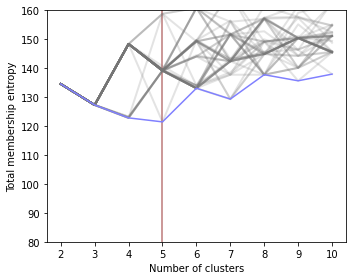

In [21]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

axes.plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
for i in range(0, total_entropies.shape[0]):
    axes.plot(np.arange(2, max_clusters+1, 1), total_entropies[i,:], color=(0.46,0.46,0.46,0.2), linewidth=2)
axes.plot(np.arange(2, max_clusters+1, 1), np.min(total_entropies,0), color=(0.5,0.5,1.0))
axes.set_xlabel('Number of clusters')
axes.set_ylabel('Total membership entropy')
axes.set_ylim(80, 160)

plt.tight_layout()
plt.show()

Contrary to the previous approach, here we don't seem to be able to correctly infer the number of clusters. Let's run the final cluster considering 5 different clusters:

In [22]:
centers, p, representative_cluster, Sx, S = run_cluster(metric_func=correlation_distance,
                                                        n_clusters=optimal_nclusters, 
                                                        data=dataset.T, 
                                                        seed=optimal_seed)
print("Total membership entropy =", np.round(S, 2))


Total membership entropy = 121.46


Let's now calculate the affinity matrices, as before:

In [23]:
#collapse-hide
### Affinity matrix - real
aux2 = np.repeat([cluter_assignment_true], cluter_assignment_true.shape[0], axis=0)
affinity_real = aux2==aux2.T
Z_real = np.array(affinity_real, dtype=float)
Z_real[affinity_real==False] = np.nan
for i in range(0, affinity_real.shape[1]):
    inds = np.where(affinity_real[i,:]==True)[0]
    Z_real[i, inds] = cluter_assignment_true[i]

### Affinity matrix - retrieved from the optimal clustering framework
aux1 = np.repeat([representative_cluster], representative_cluster.shape[0], axis=0)
affinity_clustering = aux1==aux1.T
Z_clustering = np.array(affinity_clustering, dtype=float)
Z_clustering[affinity_clustering==False] = np.nan
for i in range(0, affinity_real.shape[1]):
    inds = np.where(affinity_clustering[i,:]==True)[0]
    Z_clustering[i, inds] = representative_cluster[i]

And plot the results:

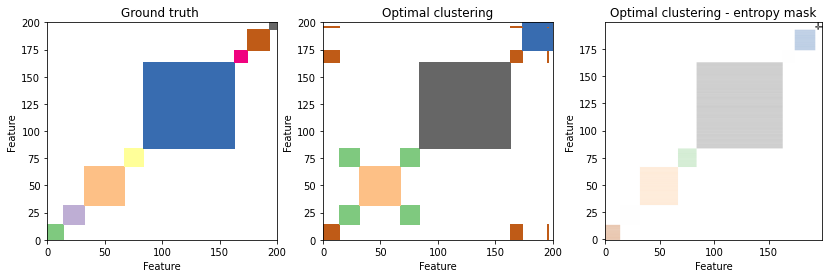

In [24]:
#collapse-hide
### Handles the colors
facecolors = list()
for i in range(0, optimal_nclusters):
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))
    
color_seq = list()
for j in range(0, n):
    color_seq.append(make_rgb_transparent(facecolors[representative_cluster[j]], 1-Sx[j]))
    
pcluster = np.zeros((n,n,3))
for i in range(0, n):
    inds = np.where(affinity_clustering[i,:]==True)[0]
    pcluster[i,inds,:] = color_seq[i]
pcluster[affinity_real==False, :] = 1

### Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].pcolor(Z_real, cmap="Accent")
axes[0].title.set_text('Ground truth ')
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Feature")
axes[1].pcolor(Z_clustering, cmap="Accent")
axes[1].title.set_text('Optimal clustering')
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Feature")
axes[2].imshow(pcluster, origin='lower')
axes[2].title.set_text('Optimal clustering - entropy mask')
axes[2].set_xlabel("Feature")
axes[2].set_ylabel("Feature")
plt.show()

Here, we can see that the framework fails to recognize the smaller clusters. Interestingly, however, from the right-most graph, we can see that the features that are mislabelled show maximum entropy, becoming fully transparent. This means that, for this subset of mislabelled features, the representative cluster bears no meaning, since the algorithm essentially fails at associating them to any of the available clusters with high confidence, which is consistent with the known ground truth. Even more important, the features that show smaller membership entropy do get correctly clustered together.

## Conclusions

From the analysis above, using the approach based on the observation matrix seems to be more effective for feature clustering. Indeed the observation matrix, by calculating the distance between each feature and all the remaining features, may be more resilient to noise. However, the number of observations is always equal to the number of features - remember that the observation matrix has size $n \times n$, with $n$ the number of features. So as the number of features increases, the dimensionality increases. Euclidean distance is known to be essentially meaningless when the number of dimensions is high. A proper assessment of each strategy will involve doing rigorous experiments with varying parameters and conditions.

**References:**

{% bibliography --cited %}